# Classification of mosquito by wingbeat frequencies

### Purpose
This dataset comes from Kaggles dataset library here: <br/> 
https://www.kaggle.com/potamitis/wingbeats <br/>
The dataset contains 279566 wav files of mosquito wingbeat audio. There are six mosquito species in the dataset. The goal is to predict the species given a short audio clip of its wingbeats.

### Research Strategy
To keep things organized this work is broken up into three notebooks:
1. Data Acquisition & Processing
2. Finetune Vgg16
3. Evaluating model performance

# 1. Data Acquisition & Processing

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import soundfile as sf
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from scipy import signal
import os
import pickle

In [2]:
pickle_path = 'Pickled/Small_Train/'

#pickle_path = 'Pickled/Train_Data/'

#pickle_path = 'Pickled/Test_Data/'

## 1.1 Fetch data

In [3]:
path = "Data/"
targets = os.listdir(path)

In [4]:
# I'm going to save a dictionary now which labels each target species from 0-5. Will one-hot encode later. 
label_dict = {targets[n]: n for n in range(6)}

# Save label dict for later use
file = open(pickle_path + 'label_dict', 'wb')
pickle.dump(label_dict, file)
file.close()

### For each target species, get all filenames of each wave file and store under fnames. Also keep labels under y. 

In [5]:
fnames=[]
y=[]

for targ in targets:
    
    for root, directories, filenames in os.walk(path+targ):
    
        for filename in filenames: 
            
            fnames.append(os.path.join(root,filename))
            y.append(targ)
            
         

In [6]:
len(fnames)

279566

### Two Hundred Seventy Nine Thousand Five Hundred and Sixty Six files!

# 1.2 Explore Data

### Based on preliminary investigations it looks like all data is 0.625 seconds in length, with a sample rate of 8000 Hz. However I want to be sure that all the files I analyze are the same when I feed them into the CNN later on.

In [13]:

for name in fnames:
    info=sf.info(name)
    
    if info.duration != 0.625:
        print(name)
        
    if info.samplerate != 8000:
        print(name)
    

    

### Above returns nothing, though it takes a few moments to run. This means that our data is uniform and already set for training.

### I want to finetune a pretrained image recognition CNN to analyze the WAV data. To get the data in a form that an image classifier can use I want to map each WAV file to a function of two variables: $I\left(f,t\right)$ which is effectively some unitless intensity as a function of frequency and time.

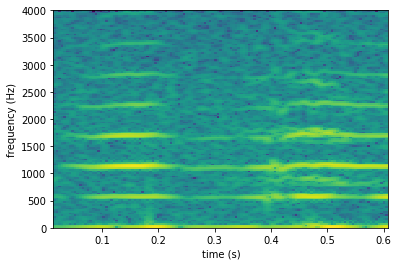

In [11]:
wave, fs = sf.read(fnames[16], dtype="float32")

Pxx, freqs, bins, im = plt.specgram(wave, NFFT=256, Fs=fs, noverlap=256-256/7)
plt.xlabel('time (s)')
plt.ylabel('frequency (Hz)')
plt.show()


### Representing the training / test data in this way has the added benefit of simultaneously capturing both the frequency and temporal features of the mosquito wingbeats.

# 1.3 Prepare data for Training 

In [12]:
df = pd.DataFrame()

df['Targets'] = y
df['f_names'] = fnames

df = shuffle(df)

df.head(8)

,Targets,f_names
238249,An. arabiensis,Data/An. arabiensis/D_17_02_02_06_41_06/F17020...
124570,Ae. aegypti,Data/Ae. aegypti/D_17_02_07_20_25_40/F170207_2...
39584,An. gambiae,Data/An. gambiae/Anopheles gambiae_ 5d-7d/D_17...
121263,Ae. aegypti,Data/Ae. aegypti/D_17_02_07_12_27_15/F170207_1...
153031,Ae. aegypti,Data/Ae. aegypti/D_17_02_09_20_28_01/F170209_2...
172085,C. quinquefasciatus,Data/C. quinquefasciatus/D_16_12_20_05_17_43/F...
98082,Ae. aegypti,Data/Ae. aegypti/D_17_02_08_10_13_13/F170208_1...
114860,Ae. aegypti,Data/Ae. aegypti/D_17_02_07_09_10_17/F170207_0...


In [13]:
# Save shuffled DF for later reference.
df.to_pickle(pickle_path + 'Targ_and_Fname_data')

### These processed files will not fit into memory as one variable. The following code converts each audio-file into a 129x129 spectrogram, normalized so that each value will be between 0 and 1, effectively making a BW image. It then stacks these images into user specified "Chunks". I'm using a chunk_size of 1024, so each chunk will be (1024,129,129). These chunks are pickled and are later unpickled in the Learning notebook.

### I'm going to take 260 samples for training, and 13 for testing.

In [14]:
df = pd.read_pickle(pickle_path + 'Targ_and_Fname_data')

In [16]:
num_chunks = 260
chunk_size = 1024

idx_offset = 0

nfft = 256


print('Working...')
for i in range(num_chunks):
            
    data = []
    targets = []
    
    for j in range(chunk_size):
        
        idx = (i-1)*chunk_size + j + idx_offset
        
        # read each audio-file using the shuffled data-frame. 
        wave, fs = sf.read(df.f_names.iloc[idx], dtype="float32")

        # Picking noverlap required some trial and error. This way ends up with 129x129 spectrum!
        # Using signal.spectrogram() is also faster than plt.specgram(), and produces no figure.
        frequencies, times, spect = signal.spectrogram(wave, nfft=nfft, fs=fs, noverlap = nfft-nfft/7)

        # Collect X data, normalize to max. Will be between 0 and 1.
        data.append(spect/np.max(spect))

        # Encode mosquito species strings as ints from 0 to 5 using label_dict. 
        # This ensures labels are the same regardless of how df is shuffled. 
        targets.append(label_dict[df.Targets.iloc[idx]])
    
    
    
    
    file = open(pickle_path + 'Spectra/Spectrum' + str(i + idx_offset), 'wb')
    pickle.dump(data,file)
    file.close()
    
    file = open(pickle_path + 'Targets/Target' + str(i + idx_offset), 'wb')
    pickle.dump(targets,file)
    file.close()
    
    
    percent_complete = round(100*(i+1)/num_chunks,1)
    print(str(percent_complete) + '% Complete', end='\r', flush=True)

print('\nDone!')


Working...
100.0% Complete
Done!


### The next notebook titled 'Learn' walks through the training of this data